In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-11-21 07:38:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2020-11-21 07:38:41 (147 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
with open("/tmp/sarcasm.json", 'r') as f:
  datastore = json.load(f)


sentences = []
labels = []

for item in datastore : 
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [5]:
len(sentences)

26709

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(24, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30

history = model.fit(training_padded, 
                    training_labels,
                    epochs=num_epochs,
                    validation_data = (testing_padded, testing_labels),
                    verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.6728 - accuracy: 0.5681 - val_loss: 0.6166 - val_accuracy: 0.6190
Epoch 2/30
625/625 - 2s - loss: 0.4526 - accuracy: 0.8185 - val_loss: 0.3958 - val_accuracy: 0.8247
Epoch 3/30
625/625 - 2s - loss: 0.3148 - accuracy: 0.8738 - val_loss: 0.3561 - val_accuracy: 0.8484
Epoch 4/30
625/625 - 2s - loss: 0.2624 - accuracy: 0.8972 - val_loss: 0.3456 - val_accuracy: 0.8553
Epoch 5/30
625/625 - 2s - loss: 0.2260 - accuracy: 0.9123 - val_loss: 0.3426 - val_accuracy: 0.8572
Epoch 6/30
625/625 - 2s - loss: 0.2005 - accuracy: 0.9243 - val_loss: 0.3505 - val_accuracy: 0.8517
Epoch 7/30
625/625 - 2s - loss: 0.1765 - accuracy: 0.9347 - val_loss: 0.3611 - val_accuracy: 0.8535
Epoch 8/30
625/625 - 2s - loss: 0.1594 - accuracy: 0.9408 - val_loss: 0.3793 - val_accuracy: 0.8477
Epoch 9/30
625/625 - 2s - loss: 0.1431 - accuracy: 0.9500 - val_loss: 0.3970 - val_accuracy: 0.8499
Epoch 10/30
625/625 - 2s - loss: 0.1301 - accuracy: 0.9549 - val_loss: 0.4082 - val_accuracy: 0.8515

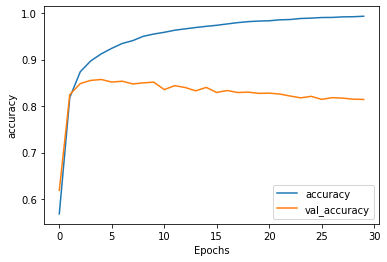

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, "val_"+string])
  plt.show()

plot_graphs(history, "accuracy")

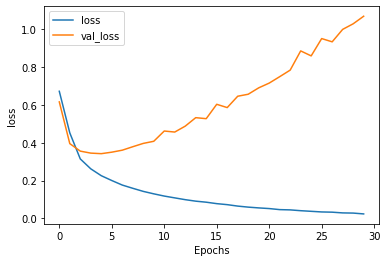

In [13]:
plot_graphs(history, "loss")

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [16]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [17]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.2166775e-01]
 [4.0890382e-06]]
